In [159]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
import scipy.stats as st
from citipy import citipy
import warnings
warnings.filterwarnings('ignore')

In [77]:
#flight data to dataframe
flight_data_df = pd.read_csv("flights_sample_3m.csv")
flight_data_df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [78]:
#separate flight date, airline, flight number, origin city, dest city, cancelled
simplified_flight_df = flight_data_df[["FL_DATE","AIRLINE","ORIGIN_CITY","DEST_CITY","DEP_DELAY","CANCELLED"]]
simplified_flight_df

,FL_DATE,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED
0,2019-01-09,United Air Lines Inc.,"Fort Lauderdale, FL","Newark, NJ",-4.0,0.0
1,2022-11-19,Delta Air Lines Inc.,"Minneapolis, MN","Seattle, WA",-6.0,0.0
2,2022-07-22,United Air Lines Inc.,"Denver, CO","Minneapolis, MN",6.0,0.0
3,2023-03-06,Delta Air Lines Inc.,"Minneapolis, MN","San Francisco, CA",-1.0,0.0
4,2020-02-23,Spirit Air Lines,"Orlando, FL","Dallas/Fort Worth, TX",-2.0,0.0
...,...,...,...,...,...,...
2999995,2022-11-13,American Airlines Inc.,"Jacksonville, FL","Charlotte, NC",-2.0,0.0
2999996,2022-11-02,American Airlines Inc.,"Chicago, IL","Austin, TX",-6.0,0.0
2999997,2022-09-11,Delta Air Lines Inc.,"Huntsville, AL","Atlanta, GA",41.0,0.0
2999998,2019-11-13,Republic Airline,"Boston, MA","New York, NY",-5.0,0.0


In [79]:
#Add Origin State
simplified_flight_df["ORIGIN_STATE"] = simplified_flight_df["ORIGIN_CITY"].str.rsplit(',').str[-1]
simplified_flight_df.head()

,FL_DATE,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE
0,2019-01-09,United Air Lines Inc.,"Fort Lauderdale, FL","Newark, NJ",-4.0,0.0,FL
1,2022-11-19,Delta Air Lines Inc.,"Minneapolis, MN","Seattle, WA",-6.0,0.0,MN
2,2022-07-22,United Air Lines Inc.,"Denver, CO","Minneapolis, MN",6.0,0.0,CO
3,2023-03-06,Delta Air Lines Inc.,"Minneapolis, MN","San Francisco, CA",-1.0,0.0,MN
4,2020-02-23,Spirit Air Lines,"Orlando, FL","Dallas/Fort Worth, TX",-2.0,0.0,FL


In [80]:
#Add Destination State
simplified_flight_df["DEST_STATE"] = simplified_flight_df["DEST_CITY"].str.rsplit(',').str[-1]
simplified_flight_df.head()

,FL_DATE,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE
0,2019-01-09,United Air Lines Inc.,"Fort Lauderdale, FL","Newark, NJ",-4.0,0.0,FL,NJ
1,2022-11-19,Delta Air Lines Inc.,"Minneapolis, MN","Seattle, WA",-6.0,0.0,MN,WA
2,2022-07-22,United Air Lines Inc.,"Denver, CO","Minneapolis, MN",6.0,0.0,CO,MN
3,2023-03-06,Delta Air Lines Inc.,"Minneapolis, MN","San Francisco, CA",-1.0,0.0,MN,CA
4,2020-02-23,Spirit Air Lines,"Orlando, FL","Dallas/Fort Worth, TX",-2.0,0.0,FL,TX


In [81]:
#Rename Column FL_Date
simplified_flight_df = simplified_flight_df.rename(columns={'FL_DATE' : 'Date'}) 
simplified_flight_df.head()

,Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE
0,2019-01-09,United Air Lines Inc.,"Fort Lauderdale, FL","Newark, NJ",-4.0,0.0,FL,NJ
1,2022-11-19,Delta Air Lines Inc.,"Minneapolis, MN","Seattle, WA",-6.0,0.0,MN,WA
2,2022-07-22,United Air Lines Inc.,"Denver, CO","Minneapolis, MN",6.0,0.0,CO,MN
3,2023-03-06,Delta Air Lines Inc.,"Minneapolis, MN","San Francisco, CA",-1.0,0.0,MN,CA
4,2020-02-23,Spirit Air Lines,"Orlando, FL","Dallas/Fort Worth, TX",-2.0,0.0,FL,TX


In [82]:
#date,state,cases : total
states = []
states = list(set(simplified_flight_df["ORIGIN_STATE"]))
print(states)
#for state in states:
  #  if state not in states:
   #     states.append(simplified_flight_df["ORIGIN_STATE"])


#unique_values_list = [df[col].unique() for col in df.columns]
#states = [simplified_flight_df["DEST_STATE"].unique() for col in simplified_flight_df.columns]
#print(states)
#covid_df = 

[' UT', ' WI', ' WA', ' ND', ' KY', ' CT', ' DE', ' FL', ' AR', ' TX', ' PA', ' NC', ' VA', ' AL', ' KS', ' DC', ' TN', ' TT', ' SD', ' NE', ' VT', ' AK', ' IL', ' OH', ' IN', ' CA', ' ID', ' IA', ' OR', ' MO', ' MT', ' MS', ' MA', ' NH', ' AZ', ' VI', ' LA', ' OK', ' NJ', ' WY', ' NM', ' ME', ' HI', ' MN', ' NY', ' MD', ' SC', ' GA', ' WV', ' CO', ' NV', ' PR', ' MI', ' RI']


In [83]:

state_list = []
#Accessing the state of New York
url = f"https://api.covidtracking.com/v2/states/ny/daily/simple.json"

state_data = requests.get(url).json()

for i in range(0,10000):

    try: 
        #state_name = state_data["data"][i]["state"]
        state_date = state_data["data"][i]["date"]
        state_case = state_data["data"][i]["cases"]["total"]
        state_list.append({"Date": state_date,
                            #"State Name": state_name,
                            "# of Cases in Covid": state_case,
                              })
        
    except:
        #print("State data not found")
        pass


print(state_list)

[{'Date': '2021-03-07', '# of Cases in Covid': 1681169}, {'Date': '2021-03-06', '# of Cases in Covid': 1674380}, {'Date': '2021-03-05', '# of Cases in Covid': 1666733}, {'Date': '2021-03-04', '# of Cases in Covid': 1657777}, {'Date': '2021-03-03', '# of Cases in Covid': 1650184}, {'Date': '2021-03-02', '# of Cases in Covid': 1642480}, {'Date': '2021-03-01', '# of Cases in Covid': 1636680}, {'Date': '2021-02-28', '# of Cases in Covid': 1630445}, {'Date': '2021-02-27', '# of Cases in Covid': 1622865}, {'Date': '2021-02-26', '# of Cases in Covid': 1614724}, {'Date': '2021-02-25', '# of Cases in Covid': 1606520}, {'Date': '2021-02-24', '# of Cases in Covid': 1597774}, {'Date': '2021-02-23', '# of Cases in Covid': 1591585}, {'Date': '2021-02-22', '# of Cases in Covid': 1584931}, {'Date': '2021-02-21', '# of Cases in Covid': 1578785}, {'Date': '2021-02-20', '# of Cases in Covid': 1572175}, {'Date': '2021-02-19', '# of Cases in Covid': 1564483}, {'Date': '2021-02-18', '# of Cases in Covid': 1

In [84]:
#Append data to dataframe, merge on date
state_case_df = pd.DataFrame(state_list)

state_case_df.head()


,Date,# of Cases in Covid
0,2021-03-07,1681169
1,2021-03-06,1674380
2,2021-03-05,1666733
3,2021-03-04,1657777
4,2021-03-03,1650184


In [85]:
#Show number of cases per month to the number of cancellations per month per state
#by_month = state_case_df.groupby(pd.Grouper(freq="M"))
#state_case_df.set_index('Date')
#pd.to_datetime(state_case_df['Date'])
#by_month = state_case_df.groupby(state_case_df['Date'].dt.month)['value'].sum()
simplified_flight_df

,Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE
0,2019-01-09,United Air Lines Inc.,"Fort Lauderdale, FL","Newark, NJ",-4.0,0.0,FL,NJ
1,2022-11-19,Delta Air Lines Inc.,"Minneapolis, MN","Seattle, WA",-6.0,0.0,MN,WA
2,2022-07-22,United Air Lines Inc.,"Denver, CO","Minneapolis, MN",6.0,0.0,CO,MN
3,2023-03-06,Delta Air Lines Inc.,"Minneapolis, MN","San Francisco, CA",-1.0,0.0,MN,CA
4,2020-02-23,Spirit Air Lines,"Orlando, FL","Dallas/Fort Worth, TX",-2.0,0.0,FL,TX
...,...,...,...,...,...,...,...,...
2999995,2022-11-13,American Airlines Inc.,"Jacksonville, FL","Charlotte, NC",-2.0,0.0,FL,NC
2999996,2022-11-02,American Airlines Inc.,"Chicago, IL","Austin, TX",-6.0,0.0,IL,TX
2999997,2022-09-11,Delta Air Lines Inc.,"Huntsville, AL","Atlanta, GA",41.0,0.0,AL,GA
2999998,2019-11-13,Republic Airline,"Boston, MA","New York, NY",-5.0,0.0,MA,NY


In [86]:
#Display all flights with origin or destination state in NY
ny_flight_df = simplified_flight_df.loc[(simplified_flight_df['ORIGIN_STATE'] == ' NY') | (simplified_flight_df['DEST_STATE'] == ' NY')]
ny_flight_df

,Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE
20,2022-05-05,JetBlue Airways,"New York, NY","Charleston, SC",-3.0,0.0,NY,SC
49,2023-07-03,JetBlue Airways,"Boston, MA","New York, NY",-10.0,0.0,MA,NY
69,2023-04-06,JetBlue Airways,"Tampa, FL","New York, NY",-9.0,0.0,FL,NY
71,2019-05-13,Delta Air Lines Inc.,"Washington, DC","New York, NY",-5.0,0.0,DC,NY
75,2019-09-12,Endeavor Air Inc.,"New York, NY","Portland, ME",-10.0,0.0,NY,ME
...,...,...,...,...,...,...,...,...
2999962,2019-02-06,United Air Lines Inc.,"Denver, CO","New York, NY",-9.0,0.0,CO,NY
2999967,2019-09-01,Alaska Airlines Inc.,"San Francisco, CA","New York, NY",-6.0,0.0,CA,NY
2999969,2022-06-05,Endeavor Air Inc.,"New York, NY","St. Louis, MO",-5.0,0.0,NY,MO
2999994,2020-08-31,Delta Air Lines Inc.,"Fort Lauderdale, FL","New York, NY",-7.0,0.0,FL,NY


In [87]:
ny_flight_df.groupby(ny_flight_df['Date']).nunique()

,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE
Date,,,,,,,
2019-01-01,16,52,47,55,1,25,23
2019-01-02,15,48,54,51,1,24,26
2019-01-03,15,54,48,50,1,26,24
2019-01-04,14,48,51,46,1,25,26
2019-01-05,14,44,49,45,1,21,25
...,...,...,...,...,...,...,...
2023-08-27,14,58,50,58,2,26,28
2023-08-28,14,51,54,58,2,27,26
2023-08-29,13,49,49,59,2,28,27


In [88]:
#Connect to main dataframe with flights
#df = pd.merge(a, b, on='id', how='inner')
complete_ny = pd.merge(ny_flight_df,state_case_df, on='Date', how='inner')
complete_ny

,Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE,# of Cases in Covid
0,2020-12-17,American Airlines Inc.,"Dallas/Fort Worth, TX","New York, NY",-7.0,0.0,TX,NY,815469
1,2020-09-21,Delta Air Lines Inc.,"New York, NY","Detroit, MI",-5.0,0.0,NY,MI,450473
2,2021-03-01,Delta Air Lines Inc.,"Los Angeles, CA","New York, NY",2.0,0.0,CA,NY,1636680
3,2020-03-10,Delta Air Lines Inc.,"Charlotte, NC","New York, NY",2.0,0.0,NC,NY,151
4,2020-03-07,Delta Air Lines Inc.,"Washington, DC","New York, NY",-6.0,0.0,DC,NY,36
...,...,...,...,...,...,...,...,...,...
26628,2020-03-21,Southwest Airlines Co.,"Baltimore, MD","Buffalo, NY",-7.0,0.0,MD,NY,10356
26629,2020-10-11,Endeavor Air Inc.,"Syracuse, NY","Detroit, MI",-5.0,0.0,NY,MI,474286
26630,2020-08-13,American Airlines Inc.,"Washington, DC","New York, NY",-11.0,0.0,DC,NY,423440
26631,2021-02-24,Delta Air Lines Inc.,"Fort Lauderdale, FL","New York, NY",-15.0,0.0,FL,NY,1597774


In [89]:
#ny_flight_df.groupby(ny_flight_df['Date']).nunique()\
#cpl = complete_ny.groupby(complete_ny(['Date', '# of Cases in Covid']))
cmpl_ny = complete_ny.loc[complete_ny["DEP_DELAY"]>0]
cmpl_ny
#count = df.groupby([(df.index.year),(df.index.month)]).count()

,Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE,# of Cases in Covid
2,2021-03-01,Delta Air Lines Inc.,"Los Angeles, CA","New York, NY",2.0,0.0,CA,NY,1636680
3,2020-03-10,Delta Air Lines Inc.,"Charlotte, NC","New York, NY",2.0,0.0,NC,NY,151
19,2020-08-02,Envoy Air,"Chicago, IL","Albany, NY",2.0,0.0,IL,NY,416298
34,2020-12-03,Mesa Airlines Inc.,"Washington, DC","New York, NY",3.0,0.0,DC,NY,674093
42,2020-06-15,Endeavor Air Inc.,"Raleigh/Durham, NC","New York, NY",30.0,0.0,NC,NY,383944
...,...,...,...,...,...,...,...,...,...
26601,2020-05-31,Southwest Airlines Co.,"Baltimore, MD","New York, NY",14.0,0.0,MD,NY,370770
26607,2020-03-08,JetBlue Airways,"Fort Myers, FL","New York, NY",4.0,0.0,FL,NY,60
26616,2020-12-17,Endeavor Air Inc.,"Detroit, MI","Syracuse, NY",27.0,0.0,MI,NY,815469
26624,2020-12-17,JetBlue Airways,"Denver, CO","New York, NY",69.0,0.0,CO,NY,815469


In [90]:
cancelled_ny = complete_ny.loc[complete_ny["CANCELLED"] == 1]
cancelled_ny

,Date,AIRLINE,ORIGIN_CITY,DEST_CITY,DEP_DELAY,CANCELLED,ORIGIN_STATE,DEST_STATE,# of Cases in Covid
11,2020-03-30,United Air Lines Inc.,"Chicago, IL","New York, NY",NaN,1.0,IL,NY,66497
23,2020-05-18,JetBlue Airways,"Rochester, NY","New York, NY",NaN,1.0,NY,NY,351371
31,2020-04-02,Allegiant Air,"Plattsburgh, NY","Sanford, FL",NaN,1.0,NY,FL,92381
38,2020-03-29,PSA Airlines Inc.,"New York, NY","Dayton, OH",NaN,1.0,NY,OH,59513
39,2020-03-26,JetBlue Airways,"New York, NY","Rochester, NY",NaN,1.0,NY,NY,37258
...,...,...,...,...,...,...,...,...,...
26571,2020-09-10,JetBlue Airways,"Rochester, NY","Boston, MA",NaN,1.0,NY,MA,441911
26575,2020-03-24,Endeavor Air Inc.,"Washington, DC","New York, NY",NaN,1.0,DC,NY,25665
26583,2020-04-07,American Airlines Inc.,"New York, NY","Dallas/Fort Worth, TX",NaN,1.0,NY,TX,138863
26585,2020-04-22,Allegiant Air,"Plattsburgh, NY","St. Petersburg, FL",NaN,1.0,NY,FL,257216


In [91]:
#df.groupby(['Week/Year', 'Category']).size()
delay_ny = cmpl_ny.groupby(['Date','# of Cases in Covid']).size().reset_index()
delay_ny

,Date,# of Cases in Covid,0
0,2020-03-02,0,43
1,2020-03-03,1,27
2,2020-03-04,1,56
3,2020-03-05,3,28
4,2020-03-06,25,53
...,...,...,...
357,2021-03-03,1650184,10
358,2021-03-04,1657777,17
359,2021-03-05,1666733,9
360,2021-03-06,1674380,13


In [92]:

#df.rename(columns={ df.columns[1]: "your value" }, inplace = True)
delay_ny.rename(columns={ delay_ny.columns[2]: "Cancellations"}, inplace=True)
delay_ny

,Date,# of Cases in Covid,Cancellations
0,2020-03-02,0,43
1,2020-03-03,1,27
2,2020-03-04,1,56
3,2020-03-05,3,28
4,2020-03-06,25,53
...,...,...,...
357,2021-03-03,1650184,10
358,2021-03-04,1657777,17
359,2021-03-05,1666733,9
360,2021-03-06,1674380,13


In [93]:
#GB=DF.groupby([DF.index.year.values,DF.index.month.values]).sum()
delay_ny['Date'] = pd.to_datetime(delay_ny['Date'])
#monthly_delay = delay_ny.groupby([delay_ny.index.year.values,delay_ny.index.month.values]).sum()
#df.groupby(df['date'].dt.strftime('%B'))['Revenue'].sum().sort_values()
#delay_ny.groupby(delay_ny)
# df.groupby(pd.Grouper(freq='M'))

#monthly
#df.groupby(pd.Grouper(key='your_date_column', freq='M'))

In [94]:
#df['month'] = df['datetime_utc'].dt.month
delay_ny['Month'] = delay_ny['Date'].dt.month
delay_ny

,Date,# of Cases in Covid,Cancellations,Month
0,2020-03-02,0,43,3
1,2020-03-03,1,27,3
2,2020-03-04,1,56,3
3,2020-03-05,3,28,3
4,2020-03-06,25,53,3
...,...,...,...,...
357,2021-03-03,1650184,10,3
358,2021-03-04,1657777,17,3
359,2021-03-05,1666733,9,3
360,2021-03-06,1674380,13,3


In [149]:
#monthly = delay_ny.groupby(pd.Grouper(key='Date',freq='m'))
#monthly_ny = delay_ny.groupby(delay_ny['Month'])['# of Cases in Covid'].sum()
#monthly_ny
#delay_ny = cmpl_ny.groupby(['Date','# of Cases in Covid']).size().reset_index()
#delay_ny

delay_ny['Date'] = pd.to_datetime(delay_ny['Date'])
monthly_ny = delay_ny.groupby(pd.Grouper(key='Date',freq='M')).sum().reset_index()

In [150]:
monthly_ny.drop(columns = 'Month')

,Date,# of Cases in Covid,Cancellations
0,2020-03-31,457174,821
1,2020-04-30,5462649,92
2,2020-05-31,8994528,77
3,2020-06-30,11139407,191
4,2020-07-31,12544553,318
5,2020-08-31,13182876,259
6,2020-09-30,13394157,206
7,2020-10-31,14940695,251
8,2020-11-30,17021398,302
9,2020-12-31,25042189,486


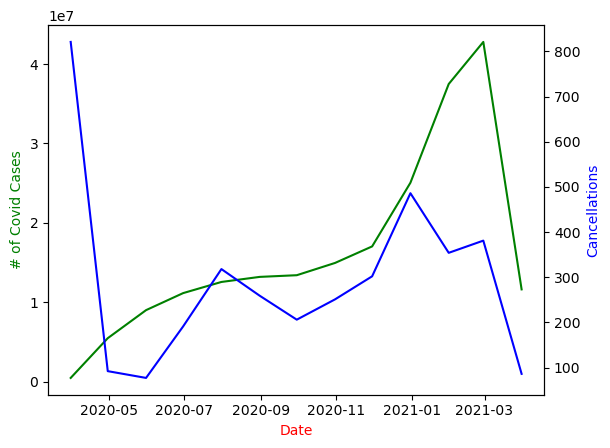

In [175]:
#Making plots to compare cancellations and number of covid cases
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

x_axis = monthly_ny['Date']
y_axis = monthly_ny['# of Cases in Covid']
y_axis2 = monthly_ny['Cancellations']

ax1.plot(x_axis,y_axis,'g-')
ax2.plot(x_axis,y_axis2,'b-')

ax1.set_xlabel('Date',color = 'r')
ax1.set_ylabel('# of Covid Cases',color='g')
ax2.set_ylabel('Cancellations',color='b')

plt.show()

In [144]:
bar_ny = monthly_ny.drop(columns = 'Cancellations')
bar_ny = bar_ny.drop(columns = 'Month')
bar_ny

,# of Cases in Covid
Date,
2020-03-31,457174
2020-04-30,5462649
2020-05-31,8994528
2020-06-30,11139407
2020-07-31,12544553
2020-08-31,13182876
2020-09-30,13394157
2020-10-31,14940695
2020-11-30,17021398


<Axes: title={'center': '# of Cases to Date'}, xlabel='Date'>

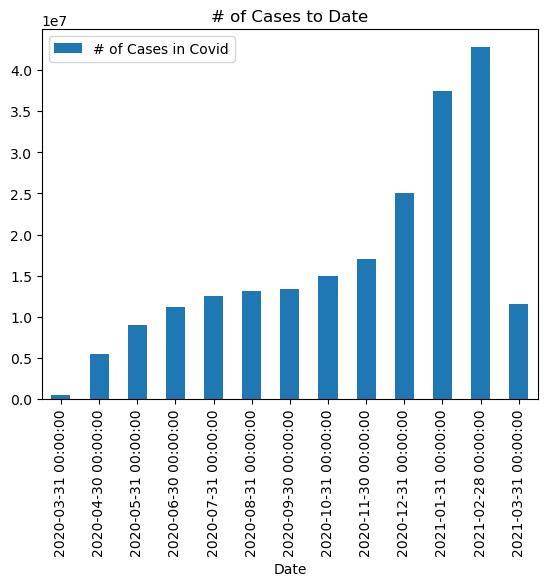

In [145]:
bar_ny.plot.bar(title = '# of Cases to Date')

<Axes: title={'center': 'Cancellations to Date'}, xlabel='Date'>

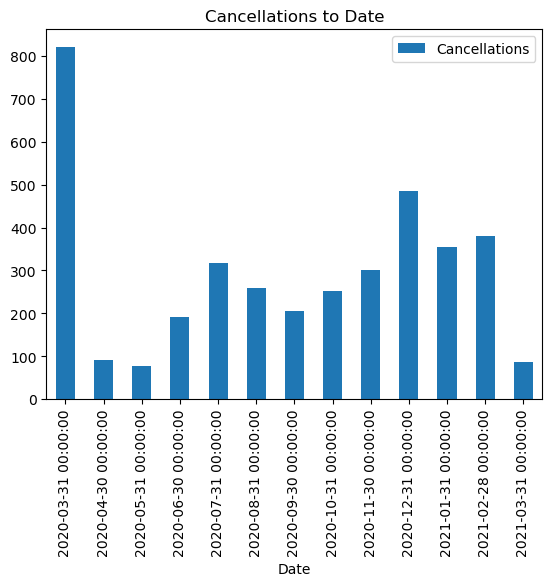

In [147]:
bar_cancel = monthly_ny.drop(columns = 'Month')
bar_cancel = bar_cancel.drop(columns = '# of Cases in Covid')
bar_cancel.plot.bar(title = "Cancellations to Date")

In [153]:
#Remove Month
scatterplot_ny = delay_ny[['Date', '# of Cases in Covid','Cancellations']].copy()
scatterplot_ny

,Date,# of Cases in Covid,Cancellations
0,2020-03-02,0,43
1,2020-03-03,1,27
2,2020-03-04,1,56
3,2020-03-05,3,28
4,2020-03-06,25,53
...,...,...,...
357,2021-03-03,1650184,10
358,2021-03-04,1657777,17
359,2021-03-05,1666733,9
360,2021-03-06,1674380,13


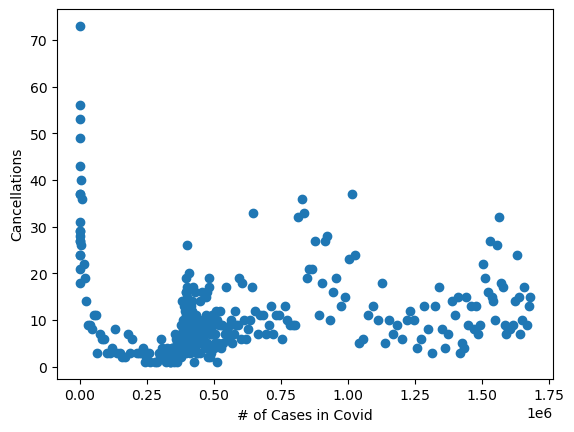

In [156]:
#Number of cancellations to number of covid cases
plt.scatter(scatterplot_ny['# of Cases in Covid'],scatterplot_ny['Cancellations'])
plt.xlabel('# of Cases in Covid')
plt.ylabel('Cancellations')
plt.show()

The correlation between Cancellations and # of Cases in Covid is 0.03


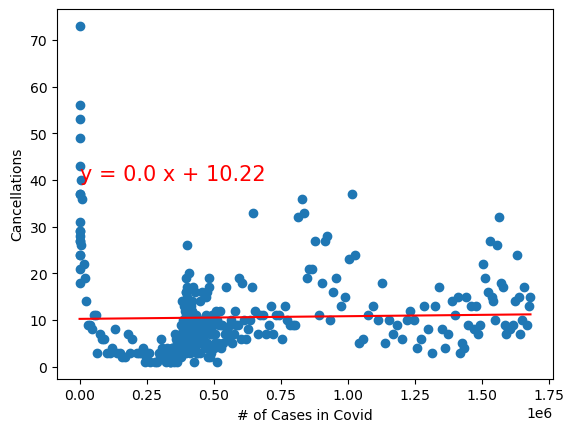

In [166]:
corr=round(st.pearsonr(scatterplot_ny['# of Cases in Covid'],scatterplot_ny['Cancellations'])[0],2)
print(f"The correlation between Cancellations and # of Cases in Covid is {corr}")

m_slope, m_int, m_rvalue, m_pvalue, m_std = st.linregress(scatterplot_ny['# of Cases in Covid'],scatterplot_ny['Cancellations'])
line_eq = "y = " + str(round(m_slope,2)) + " x + " + str(round(m_int,2))
line = m_slope*scatterplot_ny['# of Cases in Covid'] + m_int
plt.scatter(scatterplot_ny['# of Cases in Covid'],scatterplot_ny['Cancellations'])
plt.plot(scatterplot_ny['# of Cases in Covid'],line,'r')
plt.annotate(line_eq,(0.75,40), fontsize=15, color="red")
plt.xlabel('# of Cases in Covid')
plt.ylabel('Cancellations')
plt.show()